In [18]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

In [19]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [20]:
def xor(qc, elements, input, output):
    for element in elements:
        qc.cx(input[element], output)

In [21]:
clause_list = [[0,1,2,3],
               [4,5,6,7],
               [8,9,10,11],
               [12,13,14,15],
               [0,4,8,12],
               [1,5,9,13],
               [2,6,10,14],
               [3,7,11,15]]

In [22]:
def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits):
    for i in range(16):
        qc.mct([0 + 2 * i, 1 + 2 * i], var_qubits[i])
    qc.barrier()  # for visual separation
    # Use XOR gate to check each clause
    i = 0
    for clause in clause_list:
        xor(qc, clause, var_qubits, clause_qubits[i])
        i += 1
    qc.mct(clause_qubits, output_qubit)
    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        xor(qc, clause, var_qubits, clause_qubits[i])
        i += 1

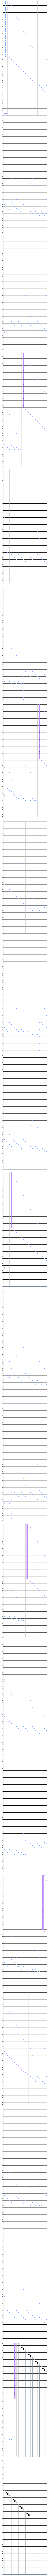

In [23]:
num_qubits = QuantumRegister(32, name='n')
var_qubits = QuantumRegister(16, name='v')
clause_qubits = QuantumRegister(16, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(32, name='cbits')
sudoku = QuantumCircuit(num_qubits, var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
sudoku.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
sudoku.h(num_qubits)
sudoku.barrier()  # for visual separation

for _ in range(6):
    sudoku_oracle(sudoku, clause_list, var_qubits, clause_qubits)
    sudoku.barrier()  # for visual separation
    # Apply our diffuser
    sudoku.append(diffuser(32), range(32))

sudoku.barrier()  # for visual separation
sudoku.measure(num_qubits, cbits)

sudoku.draw('mpl', scale= 0.5)